In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Danh sách ký tự (char_list) do bạn cung cấp
char_list = [' ', '!', '"', '#', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'À', 'Á', 'Â', 'Ê', 'Ô', 'Ú', 'Ý', 'à', 'á', 'â', 'ã', 'è', 'é', 'ê', 'ì', 'í', 'ò', 'ó', 'ô', 'õ', 'ù', 'ú', 'ý', 'Ă', 'ă', 'Đ', 'đ', 'ĩ', 'ũ', 'Ơ', 'ơ', 'Ư', 'ư', 'ạ', 'Ả', 'ả', 'Ấ', 'ấ', 'Ầ', 'ầ', 'ẩ', 'ẫ', 'ậ', 'ắ', 'ằ', 'ẳ', 'ẵ', 'ặ', 'ẹ', 'ẻ', 'ẽ', 'ế', 'Ề', 'ề', 'Ể', 'ể', 'ễ', 'Ệ', 'ệ', 'ỉ', 'ị', 'ọ', 'ỏ', 'Ố', 'ố', 'Ồ', 'ồ', 'ổ', 'ỗ', 'ộ', 'ớ', 'ờ', 'Ở', 'ở', 'ỡ', 'ợ', 'ụ', 'Ủ', 'ủ', 'Ứ', 'ứ', 'ừ', 'ử', 'ữ', 'ự', 'ỳ', 'ỵ', 'ỷ', 'ỹ']

# Định nghĩa các lớp mô hình
class LSTM_From_Scratch(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W_i = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_f = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_c = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_o = nn.Linear(input_size + hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_t, states):
        h_prev, c_prev = states
        combined = torch.cat((x_t, h_prev), dim=1)
        i_t = torch.sigmoid(self.W_i(combined))
        f_t = torch.sigmoid(self.W_f(combined))
        o_t = torch.sigmoid(self.W_o(combined))
        g_t = torch.tanh(self.W_c(combined))
        c_t = f_t * c_prev + i_t * g_t
        h_t = o_t * torch.tanh(c_t)
        h_t = self.dropout(h_t)
        return h_t, (h_t, c_t)

class BidirectionalLSTM(nn.Module):
    def __init__(self, input_dim, hidden_size, dropout=0.2):
        super().__init__()
        self.forward_lstm = LSTM_From_Scratch(input_dim, hidden_size, dropout=dropout)
        self.backward_lstm = LSTM_From_Scratch(input_dim, hidden_size, dropout=dropout)
        self.hidden_size = hidden_size

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h_f = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c_f = torch.zeros(batch_size, self.hidden_size, device=x.device)
        forward_outputs = []
        for t in range(seq_len):
            h_f, (h_f, c_f) = self.forward_lstm(x[:, t, :], (h_f, c_f))
            forward_outputs.append(h_f)
        forward_outputs = torch.stack(forward_outputs, dim=1)
        h_b = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c_b = torch.zeros(batch_size, self.hidden_size, device=x.device)
        backward_outputs = []
        for t in reversed(range(seq_len)):
            h_b, (h_b, c_b) = self.backward_lstm(x[:, t, :], (h_b, c_b))
            backward_outputs.insert(0, h_b)
        backward_outputs = torch.stack(backward_outputs, dim=1)
        outputs = torch.cat((forward_outputs, backward_outputs), dim=2)
        return outputs

class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.MaxPool2d(kernel_size=(3, 1)), nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 1))
        )
        self.rnn1 = BidirectionalLSTM(1024, 512, dropout=0.2)
        self.rnn2 = BidirectionalLSTM(1024, 512, dropout=0.2)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = x.squeeze(2)
        x = x.permute(0, 2, 1)
        x = self.rnn1(x)
        x = self.rnn2(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=2)

# Hàm xử lý ảnh đầu vào
def preprocess_image(img_path, resize_max_width=2167, height=118):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Không thể đọc ảnh từ {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = img.shape
    # Resize giữ tỷ lệ
    new_w = int(height / h * w)
    img = cv2.resize(img, (new_w, height))
    # Pad hoặc cắt để đạt kích thước cố định
    if new_w < resize_max_width:
        img = np.pad(img, ((0,0), (0, resize_max_width - new_w)), mode='median')
    else:
        img = img[:, :resize_max_width]
    # Xử lý thêm
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY_INV, 11, 4)
    img = img.astype(np.float32) / 255.
    img = np.expand_dims(img, axis=0)  # (1, H, W)
    return img

# Hàm decode CTC
def decode_ctc_greedy(output, char_list, blank_idx):
    pred_indices = torch.argmax(output, dim=1)
    decoded_text = []
    prev_idx = blank_idx
    for idx in pred_indices:
        idx = idx.item()
        if idx != blank_idx and idx != prev_idx:
            decoded_text.append(char_list[idx])
        prev_idx = idx
    return ''.join(decoded_text)

# Hàm dự đoán trên một ảnh
def predict_image(model, img_path, char_list, resize_max_width, device, blank_idx):
    img = preprocess_image(img_path, resize_max_width)
    img_tensor = torch.from_numpy(img).unsqueeze(0).to(device)  # (1, 1, H, W)
    with torch.no_grad():
        output = model(img_tensor)  # (1, T, C)
        output = output.squeeze(0)  # (T, C)
        pred_text = decode_ctc_greedy(output, char_list, blank_idx)
    return pred_text

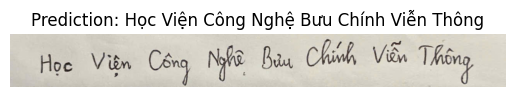

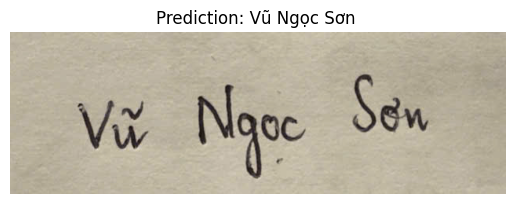

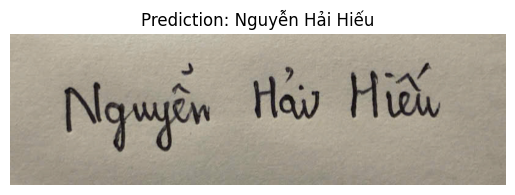

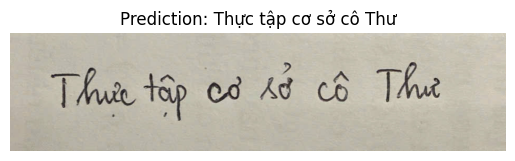

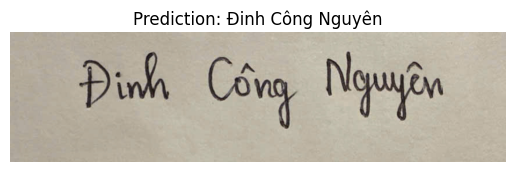

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
num_classes = len(char_list) + 1
blank_idx = num_classes - 1
model = CRNN(num_classes).to(device)
img_dir = '/content/drive/MyDrive/Colab Notebooks/data/image-test'
image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/model/best_model.pth', map_location=device))
model.to(device)
model.eval()
resize_max_width = 2167

for img_name in sorted(image_files):
    img_path = os.path.join(img_dir, img_name)
    try:

        img = Image.open(img_path)
        pred_text = predict_image(model, img_path, char_list, resize_max_width, device, blank_idx)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Prediction: {pred_text}")
        plt.show()
    except Exception as e:
        print(f"Lỗi khi xử lý ảnh {img_name}: {e}")